In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import pyomo.environ as pyo
import numpy as np
import random
import csv

from functools import reduce

from qiskit_algorithms.optimizers import SPSA, COBYLA
from qiskit_algorithms import QAOA
from qiskit.circuit.library import QAOAAnsatz
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_optimization.problems import QuadraticProgram
from qiskit_algorithms.utils import algorithm_globals

In [3]:
def coefficients(Np=10,Ns=7):
  C=np.zeros((Np, Ns, Ns))
  f1=np.zeros((Np))
  f2=np.zeros((Ns,Ns))
  random.seed(42)
  for a in range (2,Np+1):
      f1[a-1]=random.randrange(50, 1000)/1000
  for i in range (1,Ns):
      for j in range (i+1,Ns+1):
          f2[i-1,j-1]=random.randrange(100, 1000)/100
  for a in range (2,Np+1):
      for i in range (1,Ns):
          for j in range (i+1,Ns+1):
              C[a-1,i-1,j-1]=round(f1[a-1]*f2[i-1,j-1],2)
#                print(a,i,j,f1[a-1],f2[i-1,j-1],C[a-1,i-1,j-1])
  header = ['Part', 'Departure/Arrival site', 'Arrival/Departure site', 'Cost']
  dataset = []
  with open('cost_'+str(Np).zfill(2)+'_'+str(Ns).zfill(2)+'.csv', 'w') as f:
      writer = csv.writer(f)
      writer.writerow(header)
      for a in range (2,Np+1):
          for i in range (1,Ns):
              for j in range (i+1,Ns+1):
                  data=[a,i,j,C[a-1,i-1,j-1]]
                  dataset.append(data)
                  writer.writerow(data)
  f.close()
  return dataset

Np = int(input("How many different parts in PBS? (default 10)").strip() or "10")
Ns = int(input("How many different sites? (default 7)").strip() or 7)
print("Number of parts =", Np)
print("Number of sites =", Ns)
n = Ns
m = Np
N = n * m
data = coefficients(Np,Ns)
print('Cost coefficients written in file cost_'+str(Np).zfill(2)+'_'+str(Ns).zfill(2)+'.csv')

Number of parts = 5
Number of sites = 3
Cost coefficients written in file cost_05_03.csv


In [4]:
# pbs = {(2, 1), (3, 1), (4, 1), (5, 2), (6, 2), (7, 2), (8, 3), (9, 4), (10, 4)}
# psi = {(2, 3), (2, 4), (3, 4), (5, 6), (5, 7), (6, 7), (9, 10)}

pbs = {(2, 1), (3, 1), (4, 2), (5, 2)}
psi = {(2, 3), (4, 5)}

N = n * m

total_weight = sum(map(lambda x : x[3], data))
print("total_weight:", total_weight)

total_weight: 18.54


In [5]:
mdl = pyo.ConcreteModel()

N = range(n)
M = range(m)

mdl.x = pyo.Var(M, N, domain=pyo.Binary)

mdl.c1 = pyo.ConstraintList()
mdl.c2 = pyo.ConstraintList()
mdl.c3 = pyo.ConstraintList()

for r in range(m): 
  mdl.c1.add(sum(mdl.x[r, i] for i in range(n)) == 1)

for (r, s) in sorted(pbs):
  mdl.c2.add(sum(mdl.x[r - 1, i] * mdl.x[s - 1, i] for i in range(n)) == 0)

for (r, s) in sorted(psi):
  mdl.c3.add(sum(mdl.x[r - 1, i] * mdl.x[s - 1, i] for i in range(n)) == 0)

mdl.obj = pyo.Objective(
  rule=sum(w * mdl.x[r - 1, i - 1] * mdl.x[s - 1, j - 1] for a, i, j, w in data for r, s in sorted(pbs)), 
  sense=pyo.minimize
)

# with pyo.SolverFactory('gurobi', solver_io='python', manage_env=True) as opt:
#   opt.solve(mdl)
res = pyo.SolverFactory("gurobi_direct").solve(mdl)

mdl.obj.display()

x = list(map(lambda i : int(mdl.x[i].value), mdl.x))
print(x)

def total_weight(x):
  pts = {}

  part = 0
  for idx, val in enumerate(x):
    if val == int(1):
      pts[part] = idx % 3
      part += 1

  weights = 0
  for curr, parent in sorted(pbs):
    i = pts[curr - 1] + 1
    j = pts[parent - 1] + 1
    for row in data:
      if curr == row[0]:
        if i == row[1] and j == row[2]:
          weights += row[3]
        if i == row[2] and j == row[1]:
          weights += row[3]
  return weights

print("weight:", total_weight(x))
mdl.pprint()

obj : Size=1, Index=None, Active=True
    Key  : Active : Value
    None :   True :  6.67
[0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0]
weight: 6.5600000000000005
1 Var Declarations
    x : Size=15, Index={0, 1, 2, 3, 4}*{0, 1, 2}
        Key    : Lower : Value : Upper : Fixed : Stale : Domain
        (0, 0) :     0 :   0.0 :     1 : False : False : Binary
        (0, 1) :     0 :   1.0 :     1 : False : False : Binary
        (0, 2) :     0 :   0.0 :     1 : False : False : Binary
        (1, 0) :     0 :   1.0 :     1 : False : False : Binary
        (1, 1) :     0 :   0.0 :     1 : False : False : Binary
        (1, 2) :     0 :   0.0 :     1 : False : False : Binary
        (2, 0) :     0 :   0.0 :     1 : False : False : Binary
        (2, 1) :     0 :   0.0 :     1 : False : False : Binary
        (2, 2) :     0 :   1.0 :     1 : False : False : Binary
        (3, 0) :     0 :   0.0 :     1 : False : False : Binary
        (3, 1) :     0 :   0.0 :     1 : False : False : Binary
 

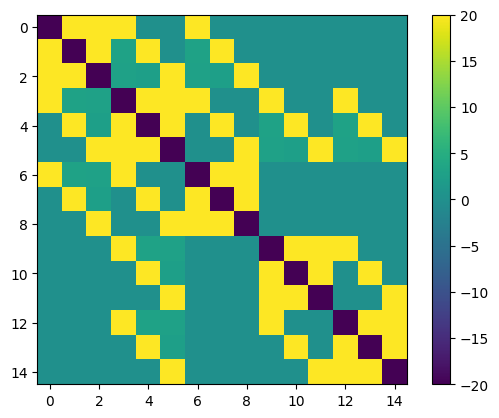

In [7]:
U = 20
N = n * m

Q = np.zeros((N, N))

P1 = U
for p in range(m):
  for a in range(p * n, (p * n) + n):
    for i in range(p * n, (p * n) + n):
      Q[a][i] = P1
    Q[a][a] *= -1

P2 = U
for r, s in sorted(pbs):
  for i in range(n):
    Q[((r - 1) * n) + i][(s * n) - n + i] = P2
    Q[(s * n) - n + i][((r - 1) * n) + i] = P2

P3 = U
for r, s in sorted(psi):
  for i in range(n):
    Q[((r - 1) * n) + i][(s * n) - n + i] = P3
    Q[(s * n) - n + i][((r - 1) * n) + i] = P3

for r, s in sorted(pbs):
  for a, i, j, w in data:
    Q[((r - 1) * n) + i - 1][((s - 1) * n) + j - 1] = w
    Q[((s - 1) * n) + j - 1][((r - 1) * n) + i - 1] = w

plt.imshow(Q)
plt.colorbar()

In [8]:
bins = [np.binary_repr(i, N) for i in range(2 ** N)]

def fun(z): return z.T @ Q @ z

def cost_fun(bins):
  costs = []
  for bin in bins:
    z = np.array(list(bin), dtype=int)
    cost = fun(z)
    costs.append(cost)
  zipped = zip(bins, costs)
  sorted_zipped = sorted(zipped, key=lambda x : x[1])
  return sorted_zipped

def get_sols(bins):
  sols = cost_fun(bins)
  return sols[:-1]

def find_sol(sol):
  sols = get_sols(bins)
  for bin, val in sols:
    if np.array_equal(sol, np.array(list(bin), dtype=int)):
      return (bin, val)

def best_sol(sols):
  best_sol = np.array(list(sols[0][0]), dtype=int)
  return best_sol

def print_sols(): return print(get_sols(bins))

# print_sols()

# best = np.array([0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0])
# print(find_sol(best))

x = best_sol(get_sols(bins))
print("best:", x)

def total_weight(x):
  pts = {}

  part = 0
  for idx, val in enumerate(x):
    if val == int(1):
      pts[part] = idx % 3
      part += 1

  weights = 0
  for curr, parent in sorted(pbs):
    i = pts[curr - 1] + 1
    j = pts[parent - 1] + 1
    for row in data:
      if curr == row[0]:
        if i == row[1] and j == row[2]:
          weights += row[3]
        if i == row[2] and j == row[1]:
          weights += row[3]
  return weights

print("weight:", total_weight(x))

best: [0 1 0 1 0 0 0 0 1 0 0 1 0 1 0]
weight: 6.5600000000000005


In [9]:
qp = QuadraticProgram()

for r in range(m):
  for i in range(n):
    qp.binary_var(f"x{r}{i}")

qp.minimize(quadratic=Q)

qubit_op, offset = qp.to_ising()
print(qubit_op.paulis, len(qubit_op.paulis), qubit_op.coeffs)

['IIIIIIIIIIIIIIZ', 'IIIIIIIIIIIIIZZ', 'IIIIIIIIIIIIIZI',
 'IIIIIIIIIIIIZIZ', 'IIIIIIIIIIIIZII', 'IIIIIIIIIIIZIIZ',
 'IIIIIIIIIIIZIII', 'IIIIIIIIZIIIIIZ', 'IIIIIIIIZIIIIII',
 'IIIIIIIIIIIIZZI', 'IIIIIIIIIIIZIZI', 'IIIIIIIIIIZIIZI',
 'IIIIIIIIIIZIIII', 'IIIIIIIIZIIIIZI', 'IIIIIIIZIIIIIZI',
 'IIIIIIIZIIIIIII', 'IIIIIIIIIIIZZII', 'IIIIIIIIIIZIZII',
 'IIIIIIIIIZIIZII', 'IIIIIIIIIZIIIII', 'IIIIIIIIZIIIZII',
 'IIIIIIIZIIIIZII', 'IIIIIIZIIIIIZII', 'IIIIIIZIIIIIIII',
 'IIIIIIIIIIZZIII', 'IIIIIIIIIZIZIII', 'IIIIIIIIZIIZIII',
 'IIIIIZIIIIIZIII', 'IIIIIZIIIIIIIII', 'IIZIIIIIIIIZIII',
 'IIZIIIIIIIIIIII', 'IIIIIIIIIZZIIII', 'IIIIIIIZIIZIIII',
 'IIIIIZIIIIZIIII', 'IIIIZIIIIIZIIII', 'IIIIZIIIIIIIIII',
 'IIZIIIIIIIZIIII', 'IZIIIIIIIIZIIII', 'IZIIIIIIIIIIIII',
 'IIIIIIZIIZIIIII', 'IIIIIZIIIZIIIII', 'IIIIZIIIIZIIIII',
 'IIIZIIIIIZIIIII', 'IIIZIIIIIIIIIII', 'IIZIIIIIIZIIIII',
 'IZIIIIIIIZIIIII', 'ZIIIIIIIIZIIIII', 'ZIIIIIIIIIIIIII',
 'IIIIIIIZZIIIIII', 'IIIIIIZIZIIIIII', 'IIIIIIZZIIIIIII',
 'IIIIZZIIIIII


   Normal return from subroutine COBYLA

   NFVALS =   67   F =-1.180838E+02    MAXCV = 0.000000E+00
   X =-7.023744E+00   5.355715E+00
None 1
{'state': 6417, 'bitstring': '001100100010001', 'value': (-290.96000000000004+0j), 'probability': 9.169751932e-05}


/Users/Quentin/Documents/hackathon/airbus/playground/venv/lib/python3.10/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/Quentin/Documents/hackathon/airbus/playground/venv/lib/python3.10/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


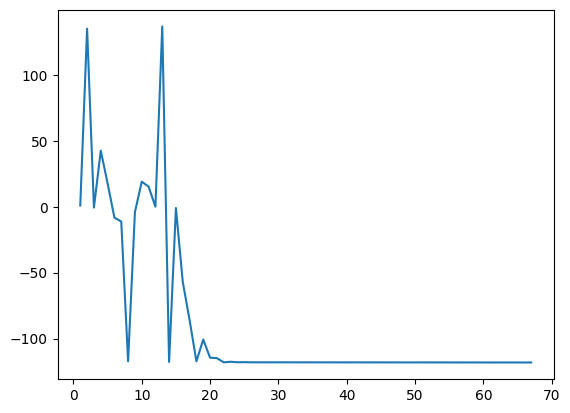

In [10]:
from qiskit.primitives import Sampler, Estimator

sampler = Sampler()
optimizer = COBYLA(disp=True)

counts, values = [], []
def store_intermediate_result(eval_count, param, mean, std):
  counts.append(eval_count)
  values.append(mean)

qaoa = QAOA(sampler=sampler, optimizer=optimizer, callback=store_intermediate_result)
result = qaoa.compute_minimum_eigenvalue(qubit_op)

print(qaoa.initial_point, qaoa.reps)
print(result.best_measurement)

plt.plot(counts, values)